In [34]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [59]:
inputs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "inputs")

# load fred description and data
des_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_description.csv'), sep=";")
fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_transf.csv'))
fred_df["date"] = pd.to_datetime(fred_df["date"])
fred_df.set_index("date", inplace=True)
raw_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_raw.csv'))
raw_fred_df["date"] = pd.to_datetime(raw_fred_df["date"])
raw_fred_df.set_index("date", inplace=True)

In [42]:
# chek for missing values
fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI              1960-01-01
T5YFFM           1960-01-01
T1YFFM           1960-01-01
TB6SMFFM         1960-01-01
TB3SMFFM         1960-01-01
                    ...    
VIXCLSx          1962-07-01
ANDENOx          1968-03-01
TWEXAFEGSMTHx    1973-02-01
UMCSENTx         1978-02-01
ACOGNO           1992-03-01
Length: 127, dtype: object

In [43]:
delete_groups = ["Interest and Exchange Rates", "Stock Market"]
delete_series = ["ACOGNO", "UMCSENTx", "TWEXAFEGSMTHx"]

# delete groups
macro_fred = []
for colname in fred_df.columns:

    if colname not in des_fred_df["fred"].values:
        continue

    group = des_fred_df[des_fred_df["fred"] == colname]["group"].values[0]

    if (group not in delete_groups) and (colname not in delete_series):
        macro_fred.append(fred_df[colname])
macro_fred_df = pd.concat(macro_fred, axis=1)

In [44]:
# chek for missing values
macro_fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI                1960-01-01
CONSPI             1960-01-01
NONREVSL           1960-01-01
REALLN             1960-01-01
BUSLOANS           1960-01-01
                      ...    
UEMP15OV           1960-01-01
UEMP5TO14          1960-01-01
MANEMP             1960-01-01
DSERRG3M086SBEA    1960-01-01
ANDENOx            1968-03-01
Length: 96, dtype: object

### 1) Daily Macro Features

In [101]:
# parameters
k = 5

# select data
X = macro_fred_df.dropna()

# compute similarity
X_similarity = cosine_distances(X)

kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


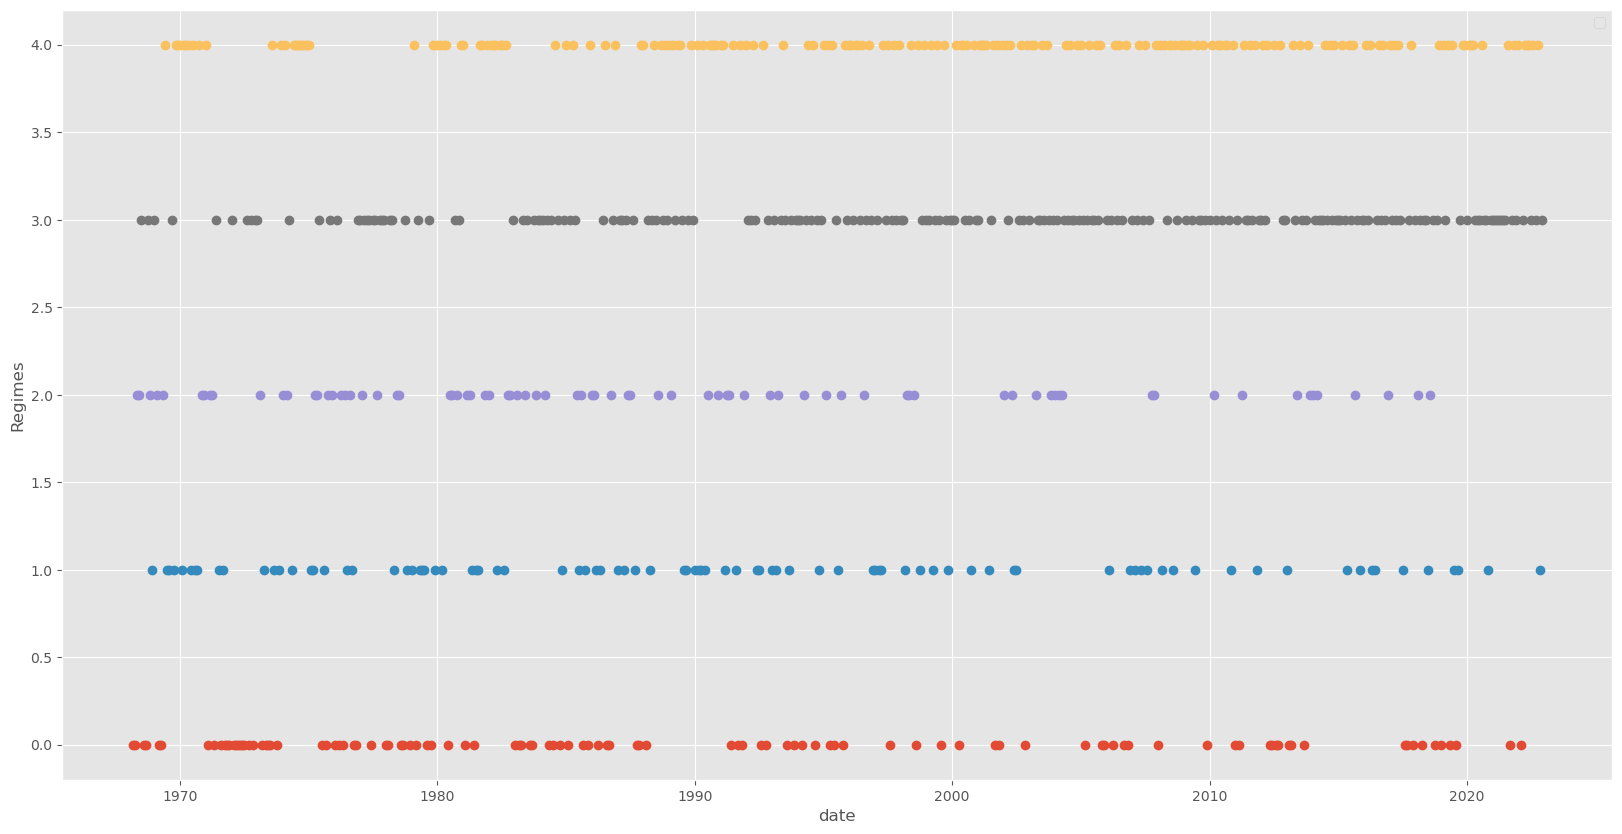

In [102]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [103]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

,S&P 500
variable,
0,0.252181
1,0.563016
2,1.370941
3,1.026027
4,0.173815


### 2) Rolling Windows of the Macro Features

In [104]:
# parameters
k = 5
window = 12

# select data
X = macro_fred_df.rolling(window=window).mean().dropna()

# compute similarity
X_similarity = cosine_distances(X)

kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


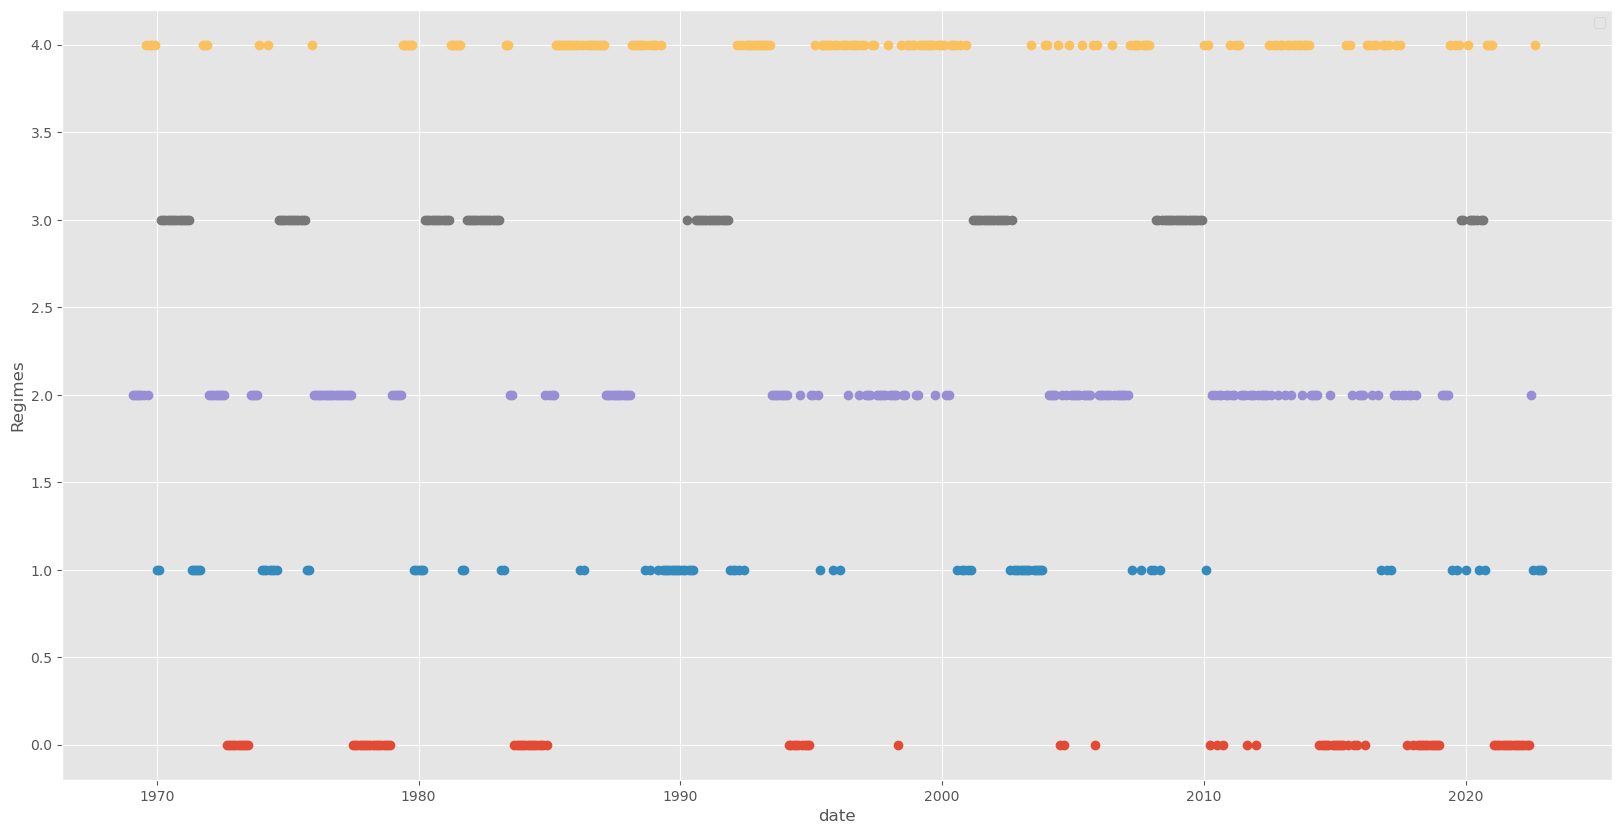

In [105]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [106]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

,S&P 500
variable,
0,0.277340
1,0.510710
2,0.587825
3,0.326663
4,1.201638


### 3) EW Windows of the Macro Features

In [107]:
# parameters
k = 5
halflife = 6

# select data
X = macro_fred_df.ewm(halflife=halflife).mean().dropna()

# compute similarity
X_similarity = cosine_distances(X)

kmeans = KMeans(n_clusters=k, random_state=0).fit(X_similarity)
X.loc[:, "cluster"] = kmeans.labels_

melt_X = X[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


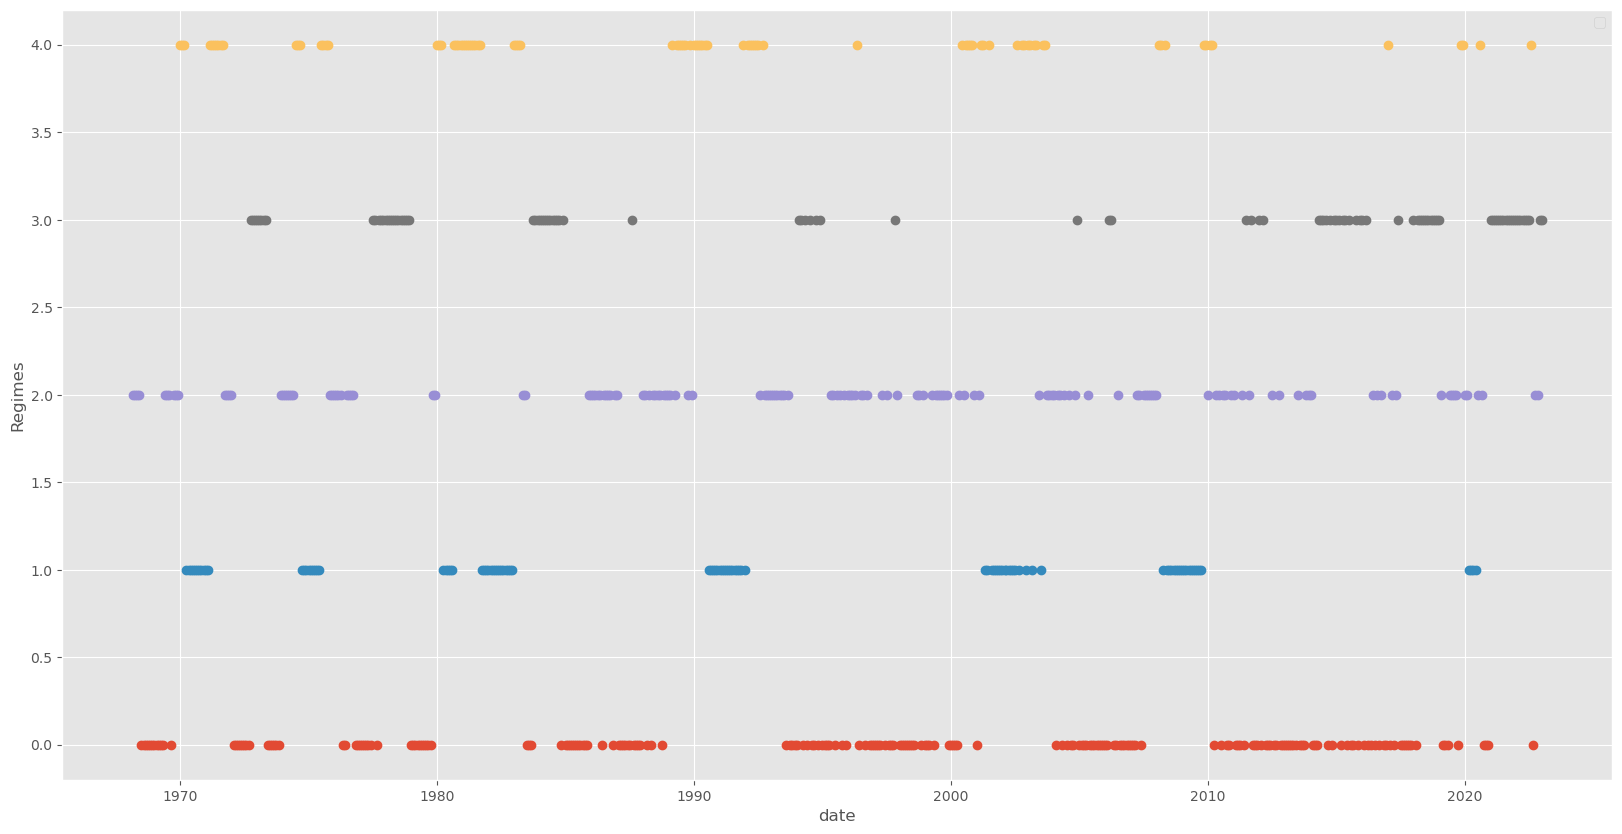

In [108]:
plt.figure(figsize=(20, 10))
plt.plot(pivot_X.index, pivot_X.values, marker="o", linestyle="")
plt.xlabel("date")
plt.ylabel("Regimes")
plt.legend()

In [109]:
regimes_df = pivot_X.copy()
regimes_df.columns = regimes_df.columns.droplevel(0)
snp_regimes_df = pd.concat([regimes_df, raw_fred_df[["S&P 500"]].pct_change().dropna()], axis=1)

pd.DataFrame(snp_regimes_df.reset_index(drop=True).melt("S&P 500").dropna().groupby("variable")["S&P 500"].mean() * 100)

,S&P 500
variable,
0,0.828454
1,0.460762
2,0.990177
3,0.306056
4,0.175818
